In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils
import numpy as np
from tqdm.notebook import tqdm
import src_loader
from util.plotting import plot_signal, LiveGraph
from models.simple_models import CNN1D_1l_RNN
from models.hippo_models import HiPPO, HiPPOMem, HiPPOMemPlainSingleSteps, HiPPOMemPlainSingleSteps2layer, HiPPOMemPlain
from model.model import Model
from train_loops import train_lambda, eval_lambda
from train_tf_keras import forward_walk_train
from model_selection import lmu_vs_gru
import train
import hippo

import nengo
import nengo_loihi

import tensorflow as tf
from tensorflow import keras
import keras_lmu

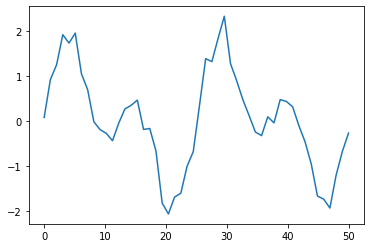

In [3]:
signal = lambda t: np.sin(t/4) + np.sin(t/2) + np.random.normal(loc=0.0, scale=0.2, size=t.shape)# + t# + np.random.normal(loc=0.0, scale=0.3, size=t.shape)
plot_signal(signal, t=50, tick_amount=50)

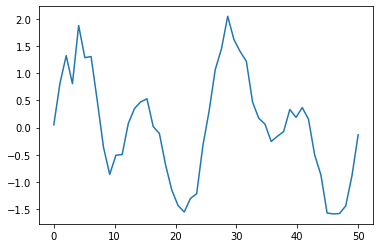

In [4]:
signal2 = lambda t: np.sin(t/4 + 2) + np.sin(t/2) + np.sin(t + 1) + np.random.normal(loc=0.0, scale=0.2, size=t.shape)# + t# + np.random.normal(loc=0.0, scale=0.3, size=t.shape)
plot_signal(signal, t=50, tick_amount=50)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
#device = torch.device("cpu")
torch.manual_seed(1)
f = 32
bs=128
tr = 48
lr=0.001
e=1000

In [6]:
#lstm = CNN1D_1l_RNN(16, int(tr/0.1), stacked=3, future = f, cell_type="LSTM")
#train_lambda(lstm, signal, future = f, time_range=tr, epochs = e, batch_size=bs, lr=lr, dev = device)

In [7]:
#gru = CNN1D_1l_RNN(16, int(tr/0.1), stacked=3, future = f, cell_type="GRU")
#train_lambda(gru, signal, future = f, time_range=tr, epochs = e, dev = device, lr=lr, batch_size=bs)

In [8]:
#hippo = HiPPO(64, 1, f)
#hippo = Model(1, 1, f, cell='orthogonal', cell_args={'hidden_size':32})
#train_lambda(hippo, signal, future = f, time_range=tr, epochs = e, batch_size=bs,lr=lr, dev=device)

In [9]:

"""hippo_mem = HiPPOMem(64, 1, f).double()
seq = torch.from_numpy(signal(np.arange(10000)))[None,None,:]
opt = optim.AdamW(hippo_mem.parameters(), lr=lr)
crit = nn.MSELoss()
with LiveGraph(backend='nbAgg') as h:
    line_pred = h.add_line()
    with tqdm(range(seq.size(2))) as pbar:
        for i in pbar:
            if i >= f+100:
                opt.zero_grad()
                out = hippo_mem(seq[:,:,0:i+1-f])
                loss = crit(out, seq[:,:,(i+1)-f:i+1][0])
                loss.backward()
                opt.step()
                line_pred.update(range(f), out.detach())
                pbar.set_postfix(loss=loss.item())"""
            

"hippo_mem = HiPPOMem(64, 1, f).double()\nseq = torch.from_numpy(signal(np.arange(10000)))[None,None,:]\nopt = optim.AdamW(hippo_mem.parameters(), lr=lr)\ncrit = nn.MSELoss()\nwith LiveGraph(backend='nbAgg') as h:\n    line_pred = h.add_line()\n    with tqdm(range(seq.size(2))) as pbar:\n        for i in pbar:\n            if i >= f+100:\n                opt.zero_grad()\n                out = hippo_mem(seq[:,:,0:i+1-f])\n                loss = crit(out, seq[:,:,(i+1)-f:i+1][0])\n                loss.backward()\n                opt.step()\n                line_pred.update(range(f), out.detach())\n                pbar.set_postfix(loss=loss.item())"

In [10]:
"""hippo_mem = HiPPOMemPlainSingleSteps(32, 1, f).double()
seq = torch.from_numpy(signal(np.arange(100000)))[None,None,:]
opt = optim.AdamW(hippo_mem.parameters(), lr=0.003)
crit = nn.MSELoss()
with LiveGraph(backend='nbAgg') as h:
    line_pred = h.add_line()
    with tqdm(range(seq.size(2))) as pbar:
        for i in pbar:
            if i >= f+100:
                opt.zero_grad()
                out = hippo_mem(seq[:,:,i-f])
                loss = crit(out, seq[:,:,(i+1)-f:i+1][0])
                loss.backward()
                opt.step()
                pbar.set_postfix(loss=loss.item())
                
                if i % 50 == 0:
                    line_pred.update(range(f), out.detach())"""

"hippo_mem = HiPPOMemPlainSingleSteps(32, 1, f).double()\nseq = torch.from_numpy(signal(np.arange(100000)))[None,None,:]\nopt = optim.AdamW(hippo_mem.parameters(), lr=0.003)\ncrit = nn.MSELoss()\nwith LiveGraph(backend='nbAgg') as h:\n    line_pred = h.add_line()\n    with tqdm(range(seq.size(2))) as pbar:\n        for i in pbar:\n            if i >= f+100:\n                opt.zero_grad()\n                out = hippo_mem(seq[:,:,i-f])\n                loss = crit(out, seq[:,:,(i+1)-f:i+1][0])\n                loss.backward()\n                opt.step()\n                pbar.set_postfix(loss=loss.item())\n                \n                if i % 50 == 0:\n                    line_pred.update(range(f), out.detach())"

In [11]:
"""hippo_mem = HiPPOMemPlain(32, 1, f).double()
seq = torch.from_numpy(signal(np.arange(10000)))[None,None,:]
opt = optim.AdamW(hippo_mem.parameters(), lr=0.003)
crit = nn.MSELoss()
with LiveGraph(backend='nbAgg') as h:
    line_pred = h.add_line()
    with tqdm(range(seq.size(2))) as pbar:
        for i in pbar:
            if i >= f+100:
                opt.zero_grad()
                out = hippo_mem(seq[:,:,0:i+1-f])
                loss = crit(out, seq[:,:,(i+1)-f:i+1][0])
                loss.backward()
                opt.step()
                line_pred.update(range(f), out.detach())
                pbar.set_postfix(loss=loss.item())"""

"hippo_mem = HiPPOMemPlain(32, 1, f).double()\nseq = torch.from_numpy(signal(np.arange(10000)))[None,None,:]\nopt = optim.AdamW(hippo_mem.parameters(), lr=0.003)\ncrit = nn.MSELoss()\nwith LiveGraph(backend='nbAgg') as h:\n    line_pred = h.add_line()\n    with tqdm(range(seq.size(2))) as pbar:\n        for i in pbar:\n            if i >= f+100:\n                opt.zero_grad()\n                out = hippo_mem(seq[:,:,0:i+1-f])\n                loss = crit(out, seq[:,:,(i+1)-f:i+1][0])\n                loss.backward()\n                opt.step()\n                line_pred.update(range(f), out.detach())\n                pbar.set_postfix(loss=loss.item())"

In [12]:
"""seq_len = 256
lmu_layer = tf.keras.layers.RNN(
    keras_lmu.LMUCell(
        memory_d=1,
        order=64,
        theta=seq_len,
        hidden_cell=tf.keras.layers.SimpleRNNCell(16),
        hidden_to_memory=False,
        memory_to_memory=False,
        input_to_hidden=True,
        kernel_initializer="ones",
    )
)
# TensorFlow layer definition
inputs = tf.keras.Input((seq_len, 1))
lmus = lmu_layer(inputs)
outputs = tf.keras.layers.Dense(f)(lmus)

# TensorFlow model definition
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()"""

'seq_len = 256\nlmu_layer = tf.keras.layers.RNN(\n    keras_lmu.LMUCell(\n        memory_d=1,\n        order=64,\n        theta=seq_len,\n        hidden_cell=tf.keras.layers.SimpleRNNCell(16),\n        hidden_to_memory=False,\n        memory_to_memory=False,\n        input_to_hidden=True,\n        kernel_initializer="ones",\n    )\n)\n# TensorFlow layer definition\ninputs = tf.keras.Input((seq_len, 1))\nlmus = lmu_layer(inputs)\noutputs = tf.keras.layers.Dense(f)(lmus)\n\n# TensorFlow model definition\nmodel = tf.keras.Model(inputs=inputs, outputs=outputs)\nmodel.summary()'

In [13]:
"""train_buff = 100
seq = tf.convert_to_tensor((signal(np.arange(10000)))[None,:,None])
opt = keras.optimizers.Adam(learning_rate=3e-3)
loss_fn = keras.losses.MSE
with LiveGraph(backend='nbAgg') as h:
    line_pred = h.add_line()
    with tqdm(range(f+seq_len + train_buff, seq.shape[1])) as pbar:
        for i in pbar:
            loss = forward_walk_train(model, seq[:,(i+1)-(seq_len+f+train_buff):i+1,:], seq_len, f, opt, loss_fn)
            line_pred.update(range(f), model(seq[:,(i+1)-(seq_len):i+1,:]))
            pbar.set_postfix(loss=loss.numpy()[0])"""
                
                

"train_buff = 100\nseq = tf.convert_to_tensor((signal(np.arange(10000)))[None,:,None])\nopt = keras.optimizers.Adam(learning_rate=3e-3)\nloss_fn = keras.losses.MSE\nwith LiveGraph(backend='nbAgg') as h:\n    line_pred = h.add_line()\n    with tqdm(range(f+seq_len + train_buff, seq.shape[1])) as pbar:\n        for i in pbar:\n            loss = forward_walk_train(model, seq[:,(i+1)-(seq_len+f+train_buff):i+1,:], seq_len, f, opt, loss_fn)\n            line_pred.update(range(f), model(seq[:,(i+1)-(seq_len):i+1,:]))\n            pbar.set_postfix(loss=loss.numpy()[0])"

In [ ]:
lmu_vs_gru(signal)

preparing models
number of GRU models: 32
number of LMU models: 64


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]